In [1]:
from sam.data_formats import load_files, DoseResponseSeries
import os
from sam import chdir_to_repopath

chdir_to_repopath()
from sam.dose_reponse_fit import (
    dose_response_fit,
    ModelPredictions,
    survival_to_stress,
    FitSettings,
    Transforms,
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
from sam.data_formats import read_data, load_files
from sam.plotting import plot_fit_prediction
from sam.system_stress import pred_surv_without_hormesis
from sam.helpers import (
    detect_hormesis_index,
    pad_c0,
    compute_lc_from_curve,
    weibull_2param,
    weibull_2param_inverse,
)
from sam.data_formats import ExperimentData

In [2]:
counts = pd.DataFrame(
    [
        pd.Series({"days": i.meta.days, "chemical": i.meta.chemical})
        for _, i in load_files()
    ]
)
counts.value_counts()

days  chemical            
2.0   Clothianidin            6
      Chlrorantraniliprole    2
7.0   Esfenvalerate           2
21.0  Copper                  2
      Esfenvalerate           2
7.0   BPS                     1
      Mix13                   1
14.0  BPS                     1
      Mix13                   1
21.0  BPS                     1
      Food Deprevation        1
      Mix13                   1
      Salt (NaCl)             1
28.0  Flupyradifurone         1
      Food Deprevation        1
      Imidachloprid           1
Name: count, dtype: int64

In [3]:
twos = [i for i in load_files() if i[1].meta.days == 2]
twentione = [i for i in load_files() if i[1].meta.days == 21]
len(twos), len(twentione)

(8, 8)

In [4]:
print([i[1].meta.title for i in twos])
print([i[1].meta.title for i in twentione])

['naemm_Clothianidin_2024_reference', 'naemm_Clothianidin_2024_agriculture', 'ayesha-cloth_Clothianidin_2021_reference', 'ayesha-cloth_Clothianidin_2021_agricultural_pre-contamination', 'ayesha-cloth_Clothianidin_2021_reference_pre-contamination', 'ayesha-cloth_Clothianidin_2021_agricultural', 'ayesha_chlorantran_2022_reference', 'ayesha_chlorantran_2022_agriculture']
['naeem_Esfenvalerate_2019_21_days', 'imrana_2024_food_21_days', 'naeem_Esfenvalerate_2024_21_days', 'naeem_Mix13_2024_21_days', 'imrana_copper_2024', 'bps_2019_21_days', 'imrana_salt_2021', 'lies_coppper_2001']


In [5]:
def compute_normalised_curve(ser: DoseResponseSeries):
    model = dose_response_fit(ser)

    if np.isnan(model.lc1):
        print("nan")
        model.lc1 = 0.0
    x = np.linspace(model.lc1, model.lc99, 1000)

    return model.model(x) * 100


def predict_cleaned_curv(data: DoseResponseSeries):
    concentration = pad_c0(data.concentration).copy()
    survival_tox_observerd = np.copy(data.survival_rate / data.meta.max_survival)

    if data.meta.hormesis_concentration is None:
        hormesis_index = detect_hormesis_index(survival_tox_observerd)

        if hormesis_index is None:
            hormesis_index = 1

    else:
        hormesis_index = np.argwhere(
            data.meta.hormesis_concentration == data.concentration
        )[0, 0]

    func, _, popt = pred_surv_without_hormesis(
        concentration=concentration,
        surv_withhormesis=survival_tox_observerd,
        hormesis_index=hormesis_index,
    )

    return func, hormesis_index, popt


def compute_cleaned_curve(data: DoseResponseSeries):
    cleaned_func, _, popt = predict_cleaned_curv(data)

    inverse = lambda x: weibull_2param_inverse(x, *popt)

    def find_lc(lc):
        lc = 1 - lc / 100
        return inverse(lc)

    lc1 = find_lc(1)
    lc99 = find_lc(99)

    x = np.linspace(lc1, lc99, 1000)
    return cleaned_func(x) * 100

In [6]:
def get_mean(series: list[ExperimentData], func: callable):
    curves = np.array([func(i[1].main_series) for i in series])
    return np.mean(curves, axis=0), np.std(curves, axis=0)

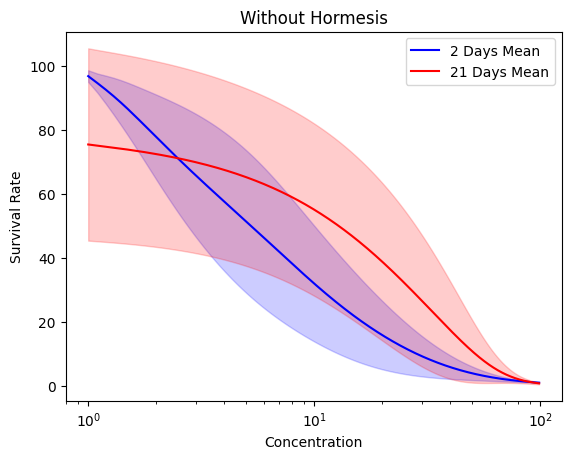

In [7]:
two_mean, two_std = get_mean(twos, compute_normalised_curve)
twentieones_mean, twentieones_std = get_mean(twentione, compute_normalised_curve)
x = np.linspace(1, 99, 1000)

plt.figure()

# Plot the mean curve for 2 days
plt.plot(x, two_mean, label="2 Days Mean", color="blue")
# Fill between mean ± std for 2 days
plt.fill_between(x, two_mean - two_std, two_mean + two_std, color="blue", alpha=0.2)

# Plot the mean curve for 21 days
plt.plot(x, twentieones_mean, label="21 Days Mean", color="red")
# Fill between mean ± std for 21 days
plt.fill_between(
    x,
    twentieones_mean - twentieones_std,
    twentieones_mean + twentieones_std,
    color="red",
    alpha=0.2,
)

# Add titles, labels, and legend
plt.title("Without Hormesis")
plt.xlabel("Concentration")
plt.ylabel("Survival Rate")
plt.legend()
plt.xscale("log")
# Show or save the plot
plt.show()

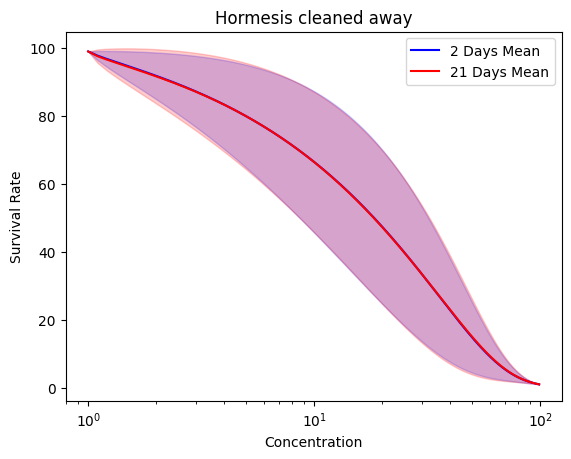

In [8]:
two_mean, two_std = get_mean(twos, compute_cleaned_curve)
twentieones_mean, twentieones_std = get_mean(twentione, compute_cleaned_curve)
x = np.linspace(1, 99, 1000)

plt.figure()

# Plot the mean curve for 2 days
plt.plot(x, two_mean, label="2 Days Mean", color="blue")
# Fill between mean ± std for 2 days
plt.fill_between(x, two_mean - two_std, two_mean + two_std, color="blue", alpha=0.2)

# Plot the mean curve for 21 days
plt.plot(x, twentieones_mean, label="21 Days Mean", color="red")
# Fill between mean ± std for 21 days
plt.fill_between(
    x,
    twentieones_mean - twentieones_std,
    twentieones_mean + twentieones_std,
    color="red",
    alpha=0.2,
)

# Add titles, labels, and legend
plt.title("Mean and Standard Deviation for 2 and 21 Days")
plt.xlabel("Concentration")
plt.ylabel("Survival Rate")
plt.legend()
plt.xscale("log")
plt.title("Hormesis cleaned away")

# Show or save the plot
plt.show()

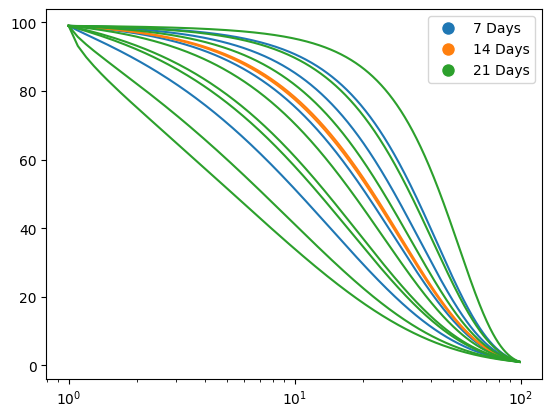

In [16]:
seven = [i for i in load_files() if i[1].meta.days == 7]
fourteen = [i for i in load_files() if i[1].meta.days == 14]
twentione = [i for i in load_files() if i[1].meta.days == 21]

x = np.linspace(1, 99, 1000)

to_color = dict(zip([7, 14, 21], plt.rcParams["axes.prop_cycle"].by_key()["color"]))

for s in seven:
    curve = compute_cleaned_curve(s[1].main_series)
    plt.plot(
        x,
        curve,
        color=to_color[7],
    )

for s in fourteen:
    curve = compute_cleaned_curve(s[1].main_series)
    plt.plot(x, curve, color=to_color[14])

for s in twentione:
    curve = compute_cleaned_curve(s[1].main_series)
    plt.plot(x, curve, color=to_color[21])

legend_elements = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor=to_color[day],
        markersize=10,
        label=f"{day} Days",
    )
    for day in [7, 14, 21]
]
plt.legend(handles=legend_elements)
plt.xscale("log")
plt.show()

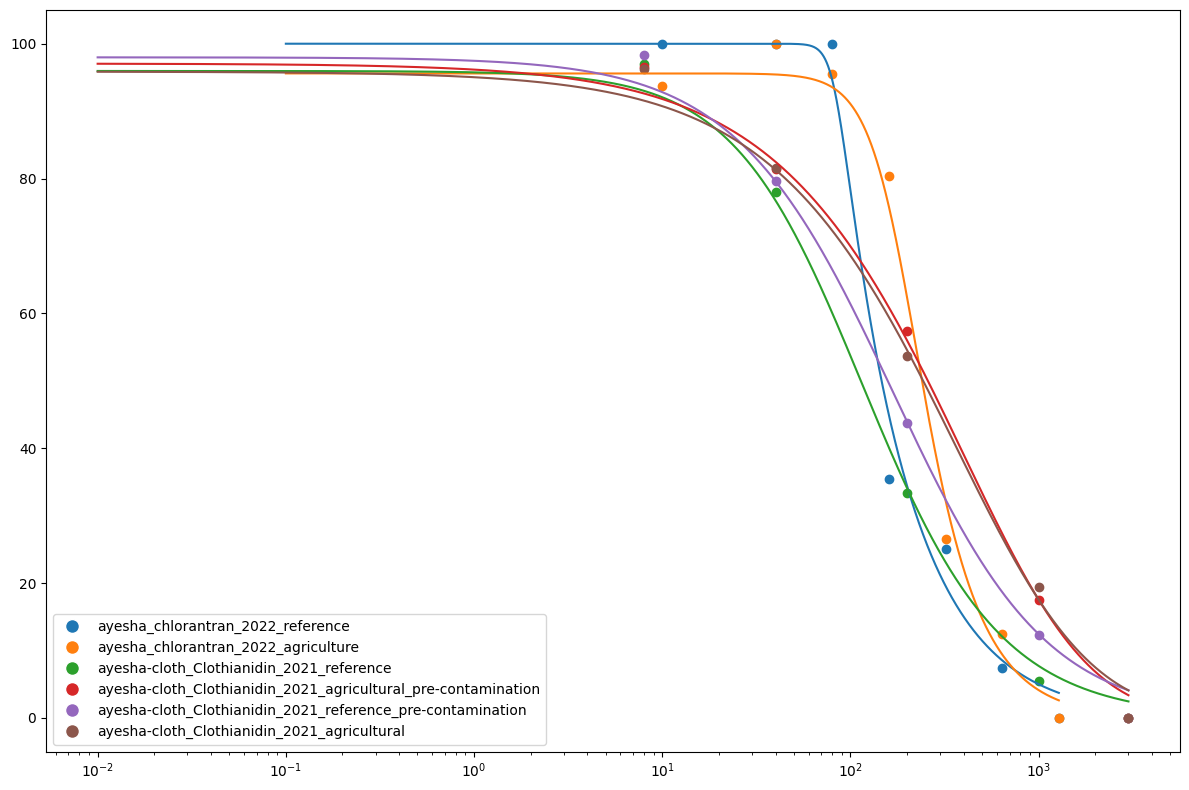

In [21]:
series = glob("data/ayesha_chlorantran_2022/*.xlsx") + glob(
    "data/ayesha-cloth_Clothianidin_2021/*.xlsx"
)
series: list[DoseResponseSeries] = [read_data(s).main_series for s in series]

color_map = {}
plt.figure(figsize=(12, 8))
for s in series:
    scatter = plt.scatter(
        s.concentration, s.survival_rate, label=f"{s.meta.title} (scatter)"
    )

    color = scatter.get_facecolor()[0]

    if s.meta.title not in color_map:
        color_map[s.meta.title] = color

    fit: ModelPredictions = dose_response_fit(s)
    plt.plot(
        fit.concentration_curve,
        fit.survival_curve,
        label=f"{s.meta.title} (fit)",
        color=color,
    )

legend_elements = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor=color_map[titel],
        markersize=10,
        label=titel,
    )
    for titel in color_map
]

plt.legend(handles=legend_elements)
plt.xscale("log")
plt.tight_layout()

plt.show()